# Applying Different Classification Algorithms to Predict the Water Potability

In this project, we plan to make a prediction to diagnose whether the water is safe to drink or not, based on certain diagnostic metrics included in the data set. We will be using different classification models such as Logistic Regression Model, K-nearest neighbors, Decision Trees, Random Forest Classifier and Support Vector Classifier. At the end, we will compare the results (accuracy and recall) of each model to see which one is performing better.

In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold # KFold for creating cross validation sets
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.pipeline import Pipeline

In [735]:
# reading dataset
df=pd.read_csv('water_potability.csv') 

In [535]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


# Checking for missing values

In [716]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

# Handling missing values

In [736]:
df.dropna(inplace=True)
# Replace NaN values with medians of those columns
#df['ph'] = df['ph'].fillna(df['ph'].median())
#df['Sulfate'] = df['Sulfate'].fillna(df['Sulfate'].median())
#df['Trihalomethanes'] = df['Trihalomethanes'].fillna(df['Trihalomethanes'].median())

In [718]:
df.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [719]:
df.dtypes

ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability           int64
dtype: object

In [737]:
#change all types to int
df.astype('int').dtypes

ph                 int64
Hardness           int64
Solids             int64
Chloramines        int64
Sulfate            int64
Conductivity       int64
Organic_carbon     int64
Trihalomethanes    int64
Turbidity          int64
Potability         int64
dtype: object

In [721]:
df.shape # the shape of our dataset

(2011, 10)

# Data visualization

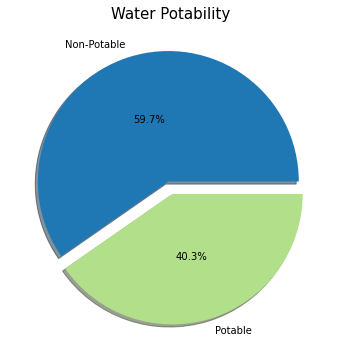

In [722]:
labels = ['Non-Potable', 'Potable']
data = [df['Potability'].value_counts()[0], df['Potability'].value_counts()[1]]
fig1, ax1 = plt.subplots(figsize=(15, 6))
ax1.pie(data, labels = labels, explode=[0.05]*2, autopct='%1.1f%%',pctdistance=0.5, shadow=True, colors = ['#1f78b4','#b2df8a'])
plt.title("Water Potability", fontsize=15);
plt.show()

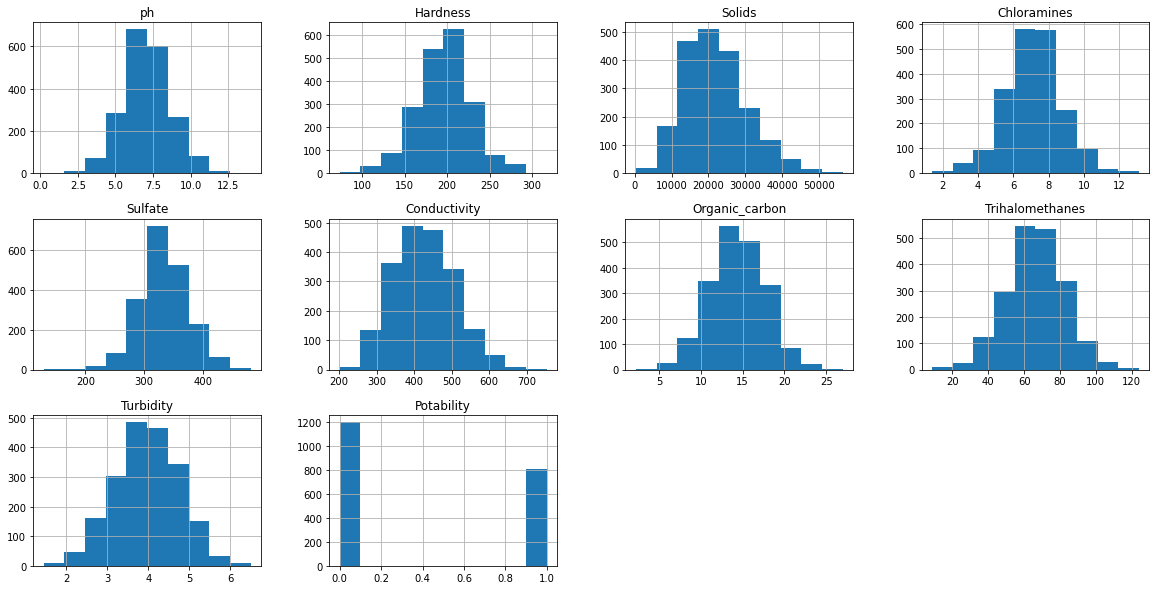

In [723]:
df.hist(figsize = (20,10), layout = (3,4))
plt.show()

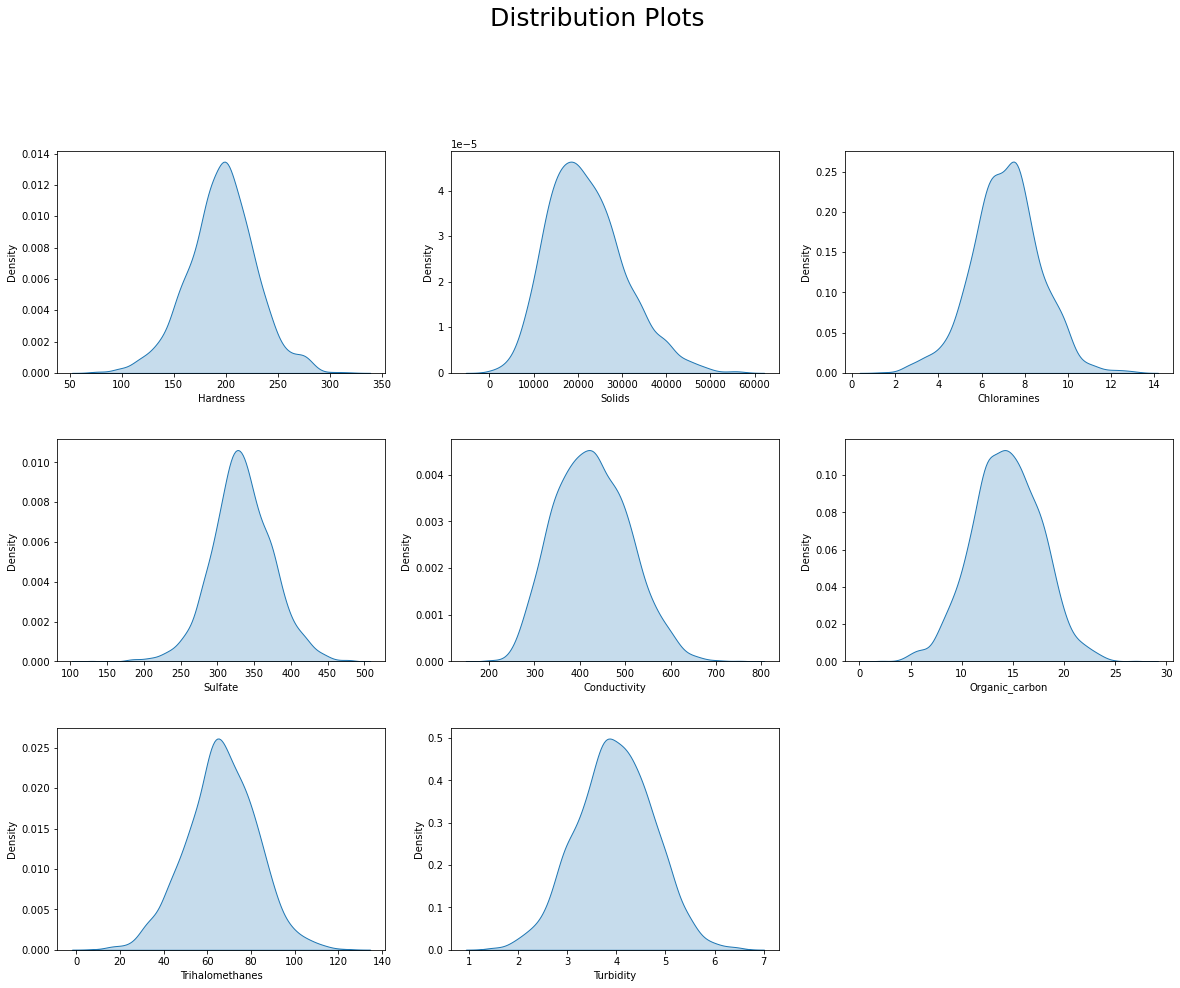

In [738]:
fig = plt.figure()
fig.suptitle("Distribution Plots", fontsize = 25)
fig.subplots_adjust(wspace = 0.2, hspace = 0.3)
for i,x in enumerate(df.iloc[:,1:-1].columns):
    ax = fig.add_subplot(4,3,i+1)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    sns.distplot(df[x], hist = False, kde_kws = {'shade': True})
plt.show()

# Feature Engineering & Pre-processing

solids graph is a little bit skewed , we will apply a transformation to fix it.

In [740]:
df['Solids'] = np.power(df['Solids'], 1/2)

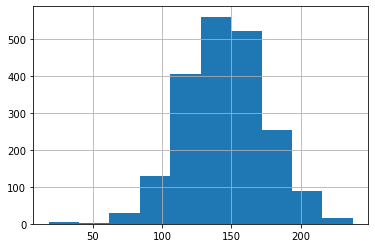

In [733]:
df['Solids'].hist()
plt.show()

<AxesSubplot:xlabel='Solids', ylabel='Density'>

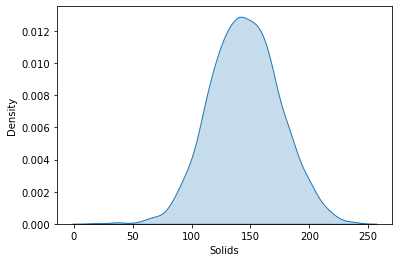

In [741]:
sns.distplot(df['Solids'], hist = False, kde_kws = {'shade' : True})

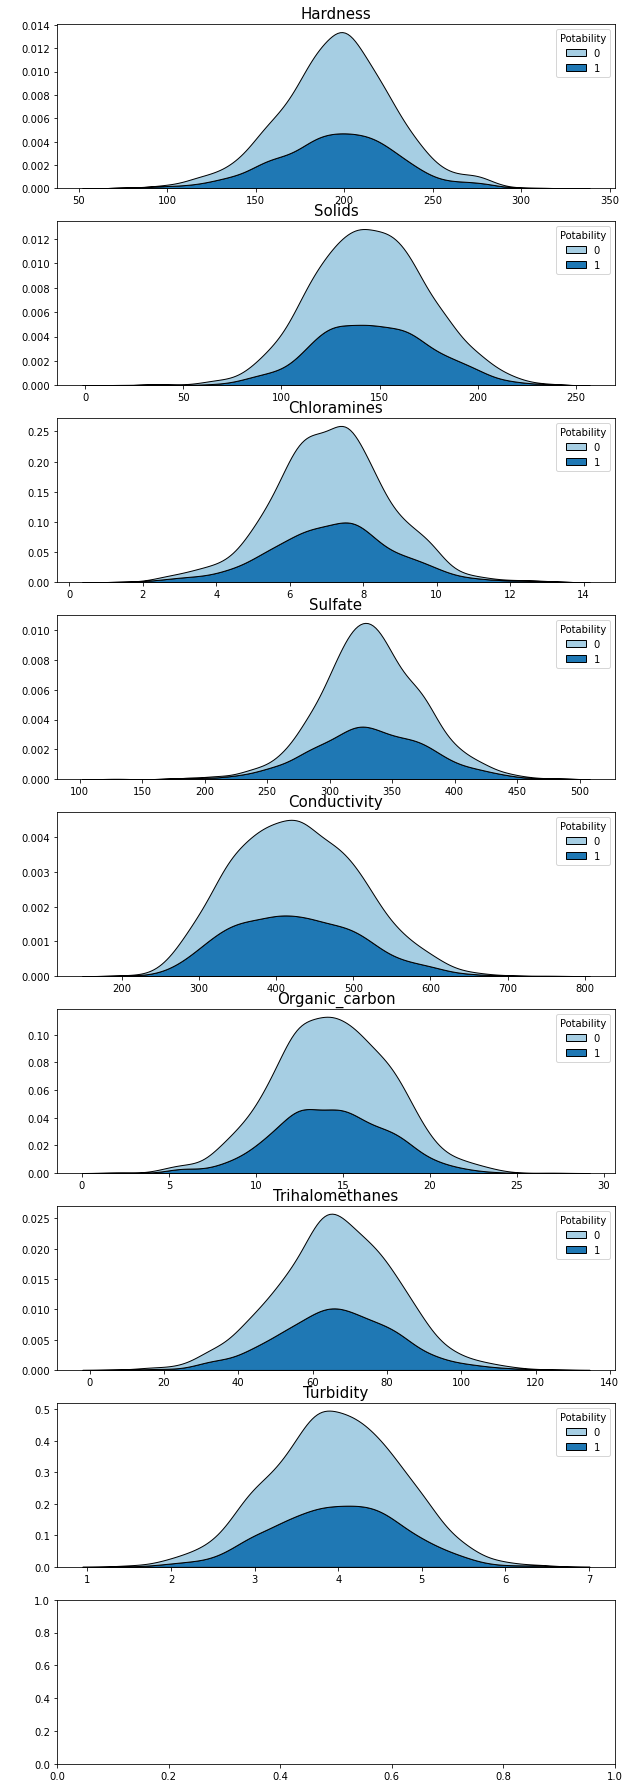

In [372]:
fig, ax = plt.subplots(nrows=9, figsize=(10, 32))
count=0
for cols in list(df.iloc[:,1:-1].columns):
    sns.kdeplot(df[cols], fill=True, alpha=1, hue = df['Potability'], 
                palette='Paired', multiple='stack', ax=ax[count]).set_title(cols, fontsize=15)
    
    ax[count].set_xlabel(' ')
    ax[count].set_ylabel(' ')
    count=count++1  
plt.show()

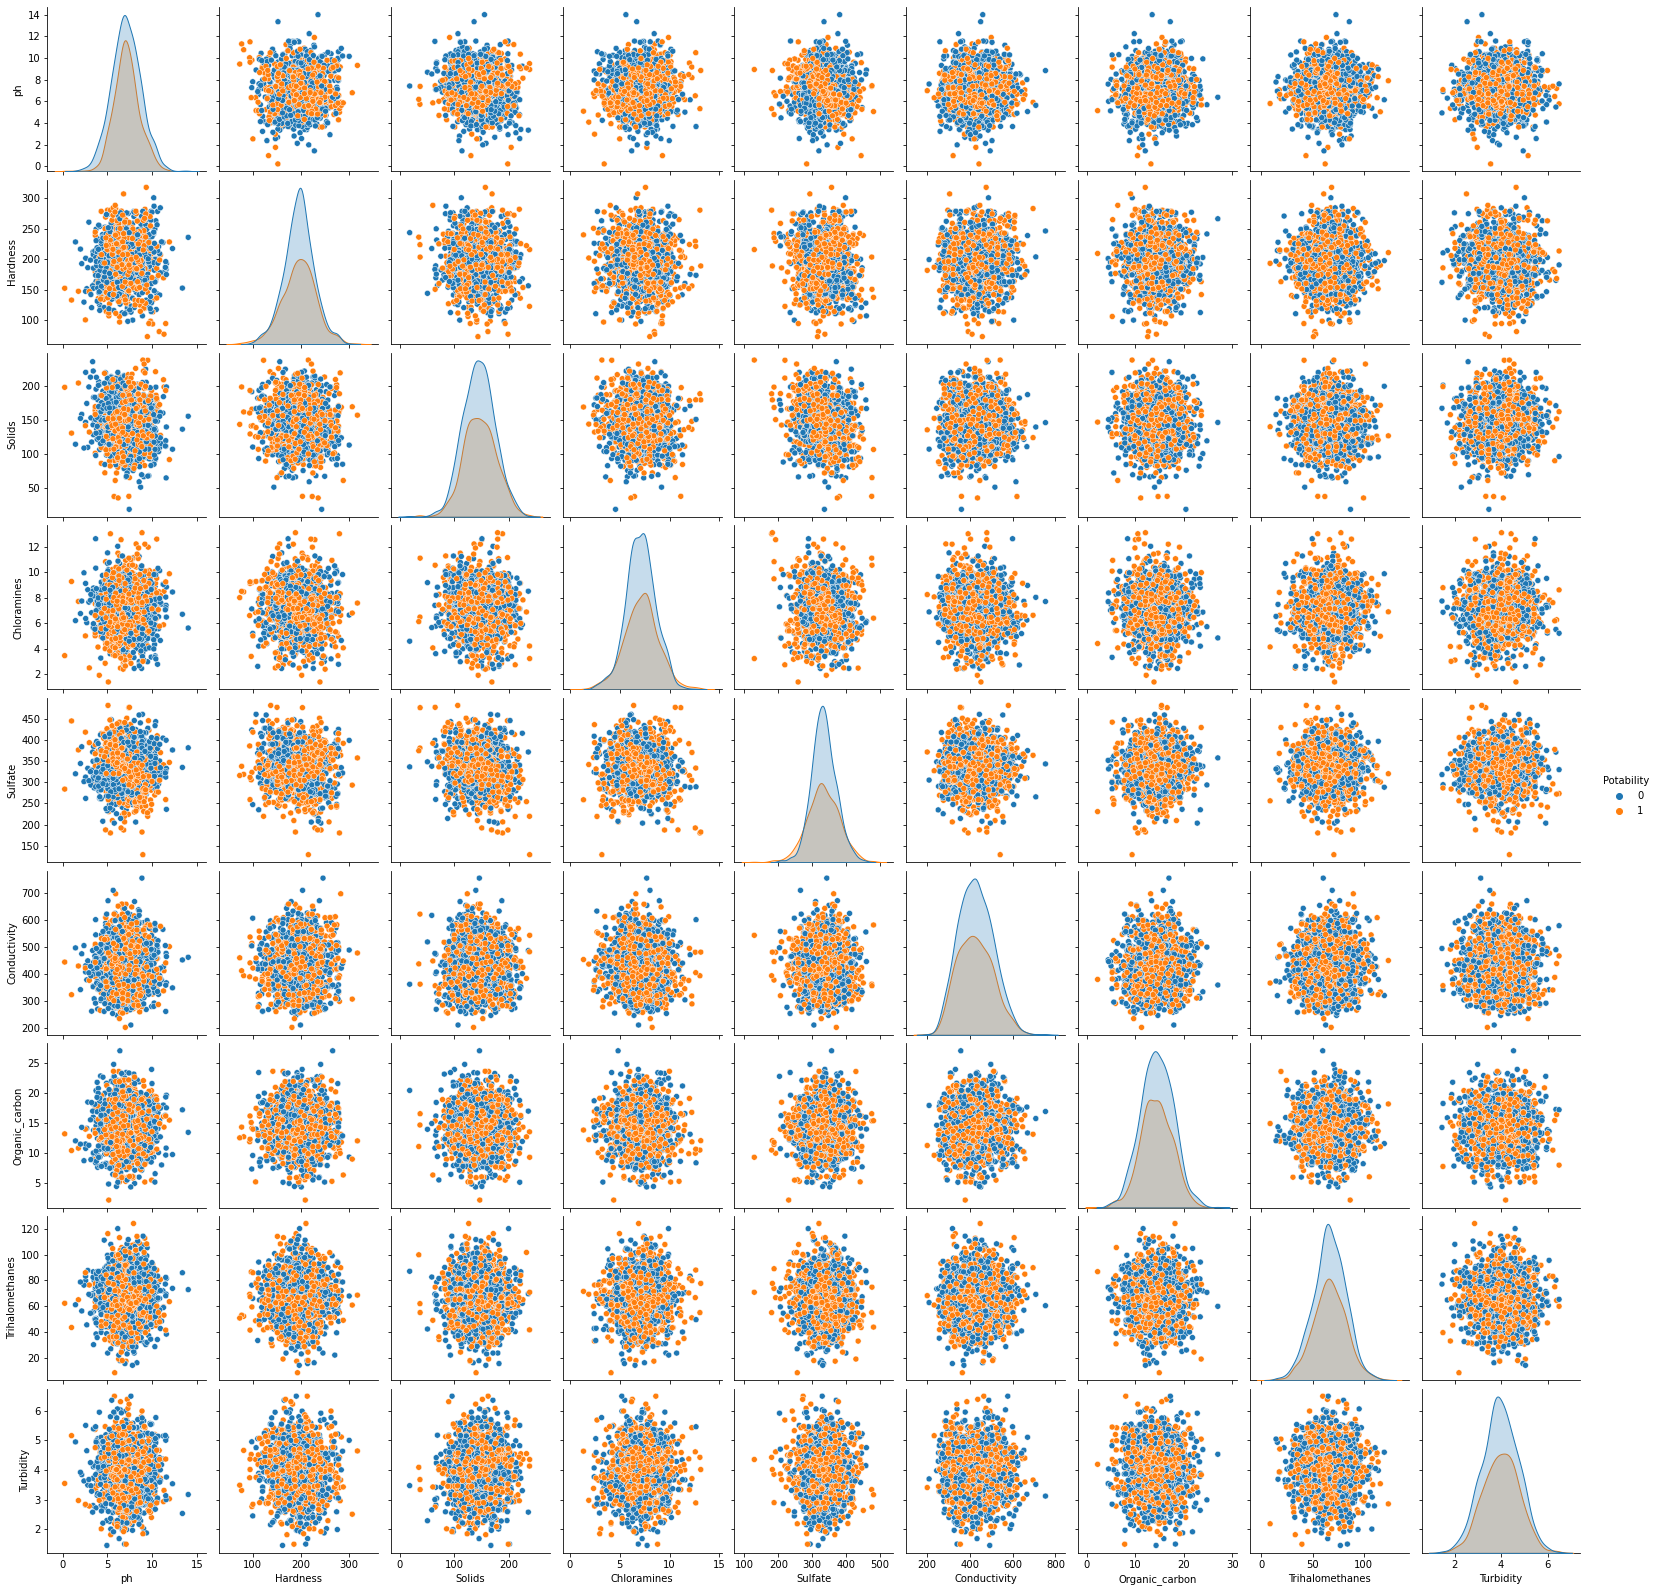

In [373]:
sns.pairplot(df, hue = "Potability")

<AxesSubplot:title={'center':'correlation matrix'}>

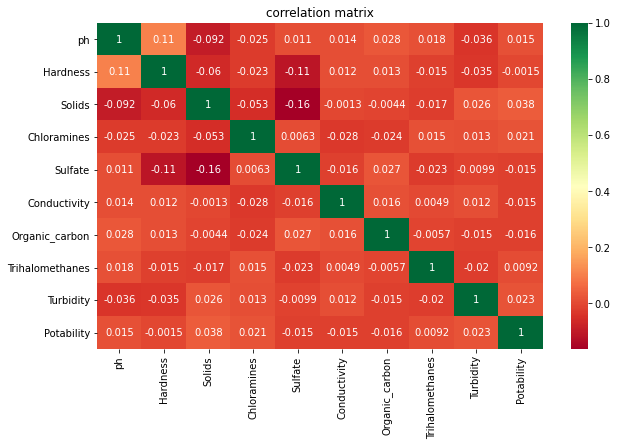

In [745]:
#corr matrix
plt.figure(figsize = (10,6))
plt.title('correlation matrix')
sns.heatmap(df.corr(), annot = True, cmap = "RdYlGn")

# Separate our features from our target

In [626]:
X = df.drop('Potability', axis = 1)
y = df['Potability']

# Splitting data into train and test sets

In [627]:
# create a training set which consists of 80% of the dataset and testing set contains 20% data
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, stratify=y)

In [628]:
# print the shapes of the new objects
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((1608, 9), (1608,), (403, 9), (403,))

In [549]:
# Standard the data
scale = StandardScaler()
scale.fit(xtrain, ytrain)
xtrain_scaled = scale.transform(xtrain)
xtest_scaled = scale.transform(xtest)

In [384]:
xtest.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
2529,7.381109,188.314378,110.997803,5.493514,343.239612,475.301884,17.826838,38.337345,4.342738
575,6.427365,202.944979,144.638347,5.527621,338.582354,332.612752,12.809024,75.101334,3.568823
2577,7.766114,212.317666,155.387856,7.925887,364.081412,464.108595,15.465256,70.105844,4.399902
3176,8.610963,125.158770,179.108277,9.844921,264.052839,342.205252,12.947376,53.950269,4.614400
2702,4.334058,155.829350,115.548318,8.603927,321.786965,387.521833,7.809445,77.879219,2.613532


In [550]:
ytest.value_counts()

0    240
1    163
Name: Potability, dtype: int64

In [551]:
ytrain.value_counts()

0    960
1    648
Name: Potability, dtype: int64

In [552]:
y.value_counts()

0    1200
1     811
Name: Potability, dtype: int64

In [554]:
# trying to balance the y 
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(xtrain, ytrain)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(ytest)}")

Training target statistics: Counter({1: 960, 0: 960})
Testing target statistics: Counter({0: 240, 1: 163})


# Logistic Regression Model

In [389]:
logreg = LogisticRegression(C=1000)
logreg.fit(xtrain_scaled, ytrain)

LogisticRegression(C=1000)

In [581]:
logreg_rec=recall_score(ytest, y_logreg)
logreg_acc = accuracy_score(ytest, y_logreg)
print(logreg_acc, confusion_matrix(ytest, y_logreg), classification_report(ytest, y_logreg), sep = '\n\n')

0.5235732009925558

[[141  99]
 [ 93  70]]

              precision    recall  f1-score   support

           0       0.60      0.59      0.59       240
           1       0.41      0.43      0.42       163

    accuracy                           0.52       403
   macro avg       0.51      0.51      0.51       403
weighted avg       0.53      0.52      0.52       403



# After balancing

In [557]:
logreg = LogisticRegression(C=1000)
logreg.fit(X_res, y_res)
y_logreg = logreg.predict(xtest_scaled)

In [586]:
logreg_rec=recall_score(ytest, y_logreg)
logreg_acc = accuracy_score(ytest, y_logreg)
print(logreg_acc, confusion_matrix(ytest, y_logreg), classification_report(ytest, y_logreg), sep = '\n\n')

0.5235732009925558

[[141  99]
 [ 93  70]]

              precision    recall  f1-score   support

           0       0.60      0.59      0.59       240
           1       0.41      0.43      0.42       163

    accuracy                           0.52       403
   macro avg       0.51      0.51      0.51       403
weighted avg       0.53      0.52      0.52       403



It gave us the same results as the original one (imbalanced) so we will just use the original one for other models.

# K-nearest nieghbours

In [559]:
knn = KNeighborsClassifier()
knn.fit(X_res, y_res)#(xtrain_scaled, ytrain)
y_knn = knn.predict(xtest_scaled)

In [560]:
knn_acc = accuracy_score(ytest, y_knn)
print(knn_acc, confusion_matrix(ytest, y_knn),
      classification_report(ytest, y_knn), sep = '\n\n')

0.5955334987593052

[[240   0]
 [163   0]]

              precision    recall  f1-score   support

           0       0.60      1.00      0.75       240
           1       0.00      0.00      0.00       163

    accuracy                           0.60       403
   macro avg       0.30      0.50      0.37       403
weighted avg       0.35      0.60      0.44       403



In [393]:
knn_acc = accuracy_score(ytest, y_knn)
print(knn_acc, confusion_matrix(ytest, y_knn),
      classification_report(ytest, y_knn), sep = '\n\n')

0.630272952853598

[[190  50]
 [ 99  64]]

              precision    recall  f1-score   support

           0       0.66      0.79      0.72       240
           1       0.56      0.39      0.46       163

    accuracy                           0.63       403
   macro avg       0.61      0.59      0.59       403
weighted avg       0.62      0.63      0.61       403



# Parameter tuning

In [473]:
from sklearn.model_selection import cross_val_score
# search for an optimal value of K for KNN
k_range = list(range(1, 20))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='recall')
    k_scores.append(scores.mean())
print(k_scores)

[0.4277476663655525, 0.197289972899729, 0.40067750677506775, 0.23538090936464914, 0.3648750376392652, 0.229223125564589, 0.32785305630834083, 0.23045769346582357, 0.30933453778982234, 0.22675398976211986, 0.3093194820837097, 0.22548931044866002, 0.2846582354712436, 0.21565793435712136, 0.2760162601626016, 0.2094549834387233, 0.2649202047576031, 0.20581150255947006, 0.2575278530563083]


Text(0, 0.5, 'Cross-Validated Accuracy')

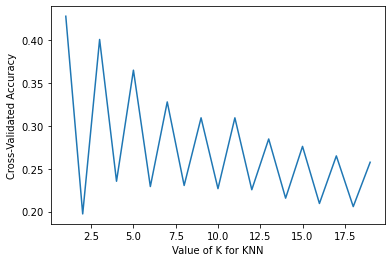

In [474]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [578]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(xtrain_scaled, ytrain)
y_knn = knn.predict(xtest_scaled)

In [580]:
knn_rec=recall_score(ytest, y_knn)
knn_acc = accuracy_score(ytest, y_knn)
print(knn_acc, confusion_matrix(ytest, y_knn),
      classification_report(ytest, y_knn), sep = '\n\n')

0.6129032258064516

[[169  71]
 [ 85  78]]

              precision    recall  f1-score   support

           0       0.67      0.70      0.68       240
           1       0.52      0.48      0.50       163

    accuracy                           0.61       403
   macro avg       0.59      0.59      0.59       403
weighted avg       0.61      0.61      0.61       403



# Decision Tree

In [480]:
dt = DecisionTreeClassifier()
dt.fit(xtrain, ytrain)
y_dt = dt.predict(xtest)

In [481]:
dt_acc = accuracy_score(ytest, y_dt)
print(dt_acc, confusion_matrix(ytest, y_dt),
      classification_report(ytest, y_dt), sep = '\n\n')

0.5682382133995038

[[152  88]
 [ 86  77]]

              precision    recall  f1-score   support

           0       0.64      0.63      0.64       240
           1       0.47      0.47      0.47       163

    accuracy                           0.57       403
   macro avg       0.55      0.55      0.55       403
weighted avg       0.57      0.57      0.57       403



# Parameter tuning

In [416]:
scores = cross_val_score(dt, X, y, cv=10, scoring='accuracy')
print(scores)

[0.54455446 0.53731343 0.56218905 0.58208955 0.55721393 0.53233831
 0.50746269 0.57711443 0.63681592 0.58706468]


Text(0, 0.5, 'Cross-Validated Accuracy')

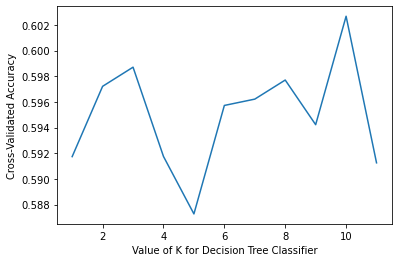

In [441]:
# search for an optimal value of K for KNN
k_range = list(range(1, 12))
k_scores = []
for k in k_range:
    dtc = DecisionTreeClassifier(max_depth = k_range)
    scores = cross_val_score(dt, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())

import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for dtc (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for Decision Tree Classifier')
plt.ylabel('Cross-Validated Accuracy')

In [573]:
dt = DecisionTreeClassifier(max_depth = 10)
dt.fit(xtrain_scaled, ytrain)
y_dt = dt.predict(xtest_scaled)

In [574]:
dt_rec=recall_score(ytest, y_dt)
dt_acc = accuracy_score(ytest, y_dt)
print(dt_acc, confusion_matrix(ytest, y_dt),
      classification_report(ytest, y_dt), sep = '\n\n')

0.6650124069478908

[[192  48]
 [ 87  76]]

              precision    recall  f1-score   support

           0       0.69      0.80      0.74       240
           1       0.61      0.47      0.53       163

    accuracy                           0.67       403
   macro avg       0.65      0.63      0.63       403
weighted avg       0.66      0.67      0.65       403



# Random Forest Classifier

In [452]:
rfc = RandomForestClassifier()
rfc.fit(xtrain, ytrain)
y_rfc = rfc.predict(xtest)

In [453]:
rfc_acc = accuracy_score(ytest, y_rfc)
print(rfc_acc, confusion_matrix(ytest, y_rfc),
      classification_report(ytest, y_rfc), sep = '\n\n')

0.7146401985111662

[[218  22]
 [ 93  70]]

              precision    recall  f1-score   support

           0       0.70      0.91      0.79       240
           1       0.76      0.43      0.55       163

    accuracy                           0.71       403
   macro avg       0.73      0.67      0.67       403
weighted avg       0.73      0.71      0.69       403



# Grid Search to find the best parameters 

In [454]:
forest_params = [{'max_depth': list(range(10, 15)), 'max_features': list(range(0,14))}]

clf = GridSearchCV(rfc, forest_params, cv = 10, scoring='accuracy')

clf.fit(xtrain, ytrain)

print(clf.best_params_)

print(clf.best_score_)

{'max_depth': 14, 'max_features': 8}
0.6884239130434784


In [567]:
rfc = RandomForestClassifier(max_depth = 14,max_features=8)
rfc.fit(xtrain_scaled, ytrain)
y_rfc = rfc.predict(xtest_scaled)

In [569]:
rfc_rec=recall_score(ytest, y_rfc)
rfc_acc = accuracy_score(ytest, y_rfc)
print(rfc_acc, confusion_matrix(ytest, y_rfc),
      classification_report(ytest, y_rfc), sep = '\n\n')

0.7196029776674938

[[213  27]
 [ 86  77]]

              precision    recall  f1-score   support

           0       0.71      0.89      0.79       240
           1       0.74      0.47      0.58       163

    accuracy                           0.72       403
   macro avg       0.73      0.68      0.68       403
weighted avg       0.72      0.72      0.70       403



# Support Vector Machine Classifier

In [563]:
svc_r=SVC(kernel='rbf', random_state=0, probability=True)
svc_r.fit(xtrain_scaled,ytrain)
svr_pred=svc_r.predict(xtest_scaled)

In [564]:
svr_acc=accuracy_score(ytest, svr_pred)
print(svr_acc, confusion_matrix(ytest, svr_pred),
      classification_report(ytest, svr_pred), sep = '\n\n')

0.7295285359801489

[[224  16]
 [ 93  70]]

              precision    recall  f1-score   support

           0       0.71      0.93      0.80       240
           1       0.81      0.43      0.56       163

    accuracy                           0.73       403
   macro avg       0.76      0.68      0.68       403
weighted avg       0.75      0.73      0.71       403



# Plot Models Accuracy Score

Text(0.5, 1.0, 'Models Accuracy')

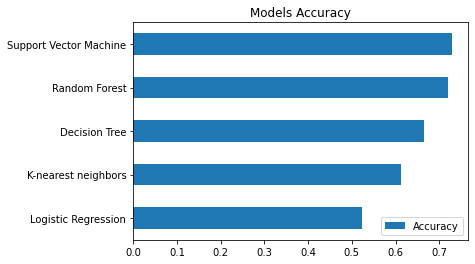

In [582]:
Accuracy_scores = [logreg_acc, knn_acc, dt_acc, rfc_acc,svr_acc]
scores_df = pd.DataFrame(Accuracy_scores, index = ['Logistic Regression', 'K-nearest neighbors', 'Decision Tree', 'Random Forest', 'Support Vector Machine'])
scores_df.rename(columns = {0 : 'Accuracy'}, inplace = True)
scores_df.plot(kind = 'barh')
plt.title('Models Accuracy')


# Plot Models Recall Score

Text(0.5, 1.0, 'Models Recall')

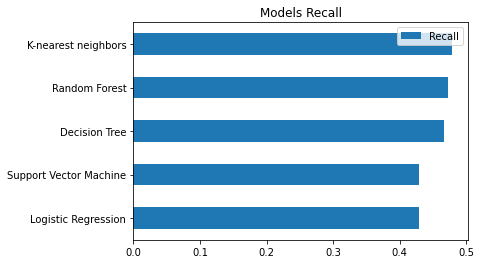

In [674]:
rec_scores = [logreg_rec, knn_rec, dt_rec, rfc_rec,svr_rec]
rec_df = pd.DataFrame(rec_scores, index = ['Logistic Regression', 'K-nearest neighbors', 'Decision Tree', 'Random Forest', 'Support Vector Machine'])
rec_df.rename(columns = {0 : 'Recall'}, inplace = True)
rec_df=rec_df.sort_values(by='Recall',ascending=True)
rec_df.plot(kind = 'barh')
plt.title('Models Recall')

In [681]:
# Load pre-trained/tuned models
model_names = ["logreg", "knn", 'dt',"rfc", "svc_r"]
model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))
model_list

[('logreg', LogisticRegression(C=1000)),
 ('knn', KNeighborsClassifier(n_neighbors=1)),
 ('dt', DecisionTreeClassifier(max_depth=10)),
 ('rfc', RandomForestClassifier(max_depth=14, max_features=8)),
 ('svc_r', SVC(probability=True, random_state=0))]

In [685]:
# Quick peek at each model performance
for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(xtest_scaled, ytest)}')

logreg score: 0.533498759305211
knn score: 0.5235732009925558
dt score: 0.5260545905707196
rfc score: 0.5459057071960298
svc_r score: 0.5806451612903226


# Voting classifier

In [467]:
from sklearn.ensemble import VotingClassifier
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='hard', #<-- sklearn calls this hard voting
                                    n_jobs=-1)
voting_classifer.fit(xtrain_scaled, ytrain)

VotingClassifier(estimators=[('logreg', LogisticRegression(C=1000)),
                             ('knn', KNeighborsClassifier(n_neighbors=16)),
                             ('dt', DecisionTreeClassifier(max_depth=10)),
                             ('rfc',
                              RandomForestClassifier(max_depth=14,
                                                     max_features=8)),
                             ('svc_r', SVC(probability=True, random_state=0))],
                 n_jobs=-1)

In [471]:
# get accuracy
y_pred = voting_classifer.predict(xtest_scaled)
accuracy_score(ytest, y_pred)

0.6898263027295285

It is not giving us better accuracy, it might be too complex for our data.